In [174]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import os
import glob
import pickle
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
plt.tight_layout()
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
from sklearn.linear_model import LinearRegression
from google.colab import drive
import argparse
import json

<Figure size 640x480 with 0 Axes>

In [175]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read the final saved dataframes containing features and targets

In [178]:
df_train = pd.read_csv("/content/drive/My Drive/DS340/train_df_1.csv")
df_test = pd.read_csv("/content/drive/My Drive/DS340/test_df_1.csv")

In [179]:
args = argparse.Namespace(config_path="/content/drive/My Drive/DS340/config.json")
args2 = argparse.Namespace(questions_path="/content/drive/My Drive/DS340/questions_dict.json")

In [180]:
with open(args.config_path) as json_file:
  config_dict = json.load(json_file)

with open(args2.questions_path) as json_file:
  questions_dict = json.load(json_file)

In [138]:
df_train.head()

,feature_financial_1,feature_financial_2,feature_financial_3,feature_financial_4,feature_financial_5,target_12m,feature_financial_7,feature_financial_8,feature_management_1,feature_management_2,feature_management_3,sp500_12m,report_date,start_date,end_date,symbol,era,target_max_normalised,target_min_normalised,target_3m_normalised,target_6m_normalised,target_9m_normalised,target_12m_normalised,target_ml
0,24.811103,-2.732515,4.069559,3.384748,9.046729,26.335992,10.497585,-2.035153,0.172511,7.836455,7.841908,10.969770,2004-07-14,2004-07-16,2005-07-12,CASY,2004,0.111411,0.713064,0.339981,-0.050558,-0.152196,0.540707,0.75
1,37.902205,-10.584720,-3.925111,10.519092,29.277028,-0.239121,14.012032,-10.184125,-4.393434,-3.836750,6.401449,11.198894,2010-03-16,2010-03-18,2011-03-14,GTY,2010,0.376838,-0.266038,-0.433935,0.433935,0.724871,-0.976794,0.00
2,15.625932,-15.707024,12.463565,-4.801985,5.278909,-14.041366,1.365148,-11.103384,1.354032,-0.025270,-2.110182,-11.092990,2015-02-17,2015-02-19,2016-02-14,LYB,2015,0.102791,-0.043990,0.967422,-0.206683,0.088066,-0.454981,0.25
3,35.050093,-75.572047,-6.926406,-26.654301,-71.243042,-63.512677,19.105920,1.909901,6.328505,6.948241,13.568766,19.251907,2016-03-08,2016-03-10,2017-03-11,DVAX,2016,0.311156,-2.765600,-1.192783,-1.721130,-2.765600,-2.765600,0.00
4,17.687976,-18.150889,10.884524,-5.302050,-4.460844,2.892501,8.411509,-3.156175,1.791278,3.153029,6.538060,7.941830,2005-03-16,2005-03-18,2006-03-13,CHDN,2005,-0.369171,-0.719229,0.618873,-0.885290,-0.946291,-0.745450,0.25


## Questions used to generate training and testing features by querying ChatGPT 3.5 Turbo



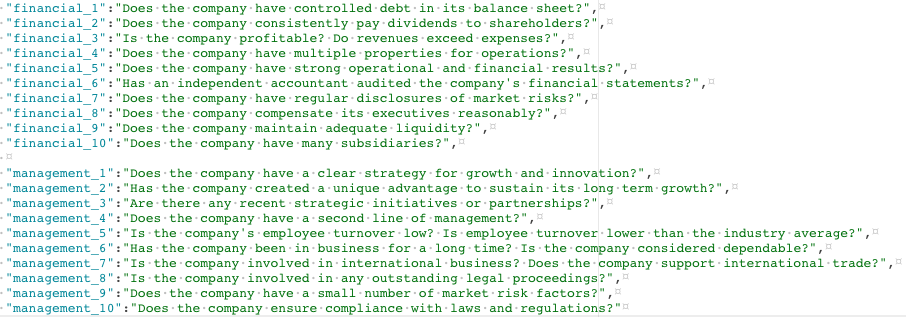

In [184]:
feature_cols = ["feature_financial_8", "feature_management_1", "feature_management_2", "feature_management_3", "sp500_12m"]

In [ ]:
# target_custom_22 corresponds to target created from 12 month normalised returns per year (aka era) and then binned
# refer make_targets.py for more details
df_train['target_12m_normalised'].unique()

In [ ]:
# target_custom_2 corresponds to target created from max normalised returns in the span of 12 months per year (aka era) and then binned
# refer make_targets.py for more details
df_train['target_min_normalised'].unique()

**Note**: '12 month normalised' returns refers to returns during the period between 2 successive annual report filings.
'max normalised returns' also refers to the same period but calculates returns from the annual report date to the date
when max return ($98^{th}$ percentile) was achieved during that period

## Linear Regression Model

In [187]:
reg_12m = LinearRegression(positive=True).fit(df_train[feature_cols],
                                           df_train['target_12m_normalised'])
reg_max = LinearRegression(positive=True).fit(df_train[feature_cols],
                                           df_train['target_min_normalised'])

df_test['pred_reg_12m'] = reg_12m.predict(df_test[feature_cols])
df_test['pred_reg_max'] = reg_max.predict(df_test[feature_cols])

## Analyse top predicted stocks

In [188]:
def calc_returns(df_test, top_k, returns_col, pred_col):
    '''
    Function to calculate the mean returns across all years.
    Finds out the top predicted stocks each year and then computes mean returns.
    Args:
        df_test: Test df containing the return column and the predicted column.
        top_k: Top 'k' stocks to select based on 'pred_col'.
        returns_col: Column containing the raw returns for that period.
        pred_col: Column containing the prediction of the ML model.
    Returns:
        Dictionary with Mean returns of predicted stocks and the S&P500 index for the same duration.
        Results are averaged across all years.
    '''
    ret_dict = {}
    #Get list of top_k predicted stocks for each year (aka era)
    top_pred_id_list = list(df_test.groupby('era', group_keys=False).apply(lambda d: d.sort_values(by=pred_col, ascending=False).iloc[:top_k]['symbol']))

    #Filter the df to contain only top_k predicted stocks
    df_toppred = df_test.loc[lambda x: x['symbol'].isin(top_pred_id_list)].sort_values(by='era')

    #Compute the average returns in each year. The resulting df will contain percent returns for each year.
    returns_agg_df = df_toppred.loc[:, ['era', 'sp500_{}'.format(returns_col), 'target_{}'.format(returns_col)]].groupby('era').agg('mean')

    ret_dict['top_k'] = top_k
    #Calculate average percent returns across all years.
    ret_dict['sp500_mean'] = returns_agg_df['sp500_{}'.format(returns_col)].mean()
    ret_dict['gpt_mean'] = returns_agg_df['target_{}'.format(returns_col)].mean()
    return ret_dict

In [189]:
#Find top stocks based on prediction by 'reg_12m' model.
#Calculate returns for entire 12 month duration
df_eval_12m = pd.DataFrame()

#k denotes the number of top stocks to be selected per year.
for k in range(1, 21):
    curr_df = pd.DataFrame.from_dict(calc_returns(df_test, k, returns_col='12m', pred_col='pred_reg_12m'), orient='index').T
    curr_df.set_index('top_k', inplace=True)
    df_eval_12m = pd.concat([df_eval_12m, curr_df], ignore_index=False)

Text(0.5, 0, 'Top k Selected Stocks')

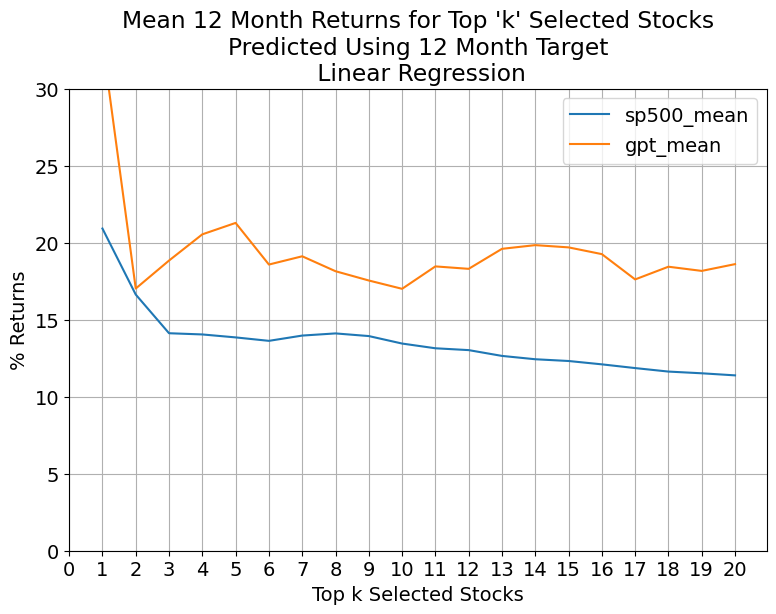

In [190]:
df_eval_12m.loc[:, ['sp500_mean', 'gpt_mean']].plot(figsize=(9,6))
plt.grid()
plt.title("Mean 12 Month Returns for Top 'k' Selected Stocks\nPredicted Using 12 Month Target\n Linear Regression")
plt.ylabel('% Returns')
plt.ylim(0, 30)
plt.xticks(range(0, 21, 1))
plt.xlabel('Top k Selected Stocks')
#plt.savefig("plots/12mReturns_12mTarget.png", dpi=300)

In [191]:
#Find top stocks based on prediction by 'reg_max' model.
#Calculate returns for entire 12 month duration
df_eval_max = pd.DataFrame()

#k denotes the number of top stocks to be selected per year.
for k in range(1, 21):
    curr_df = pd.DataFrame.from_dict(calc_returns(df_test, k, returns_col='12m', pred_col='pred_reg_max'), orient='index').T
    curr_df.set_index('top_k', inplace=True)
    df_eval_max = pd.concat([df_eval_max, curr_df], ignore_index=False)

Text(0.5, 0, 'Top k Selected Stocks')

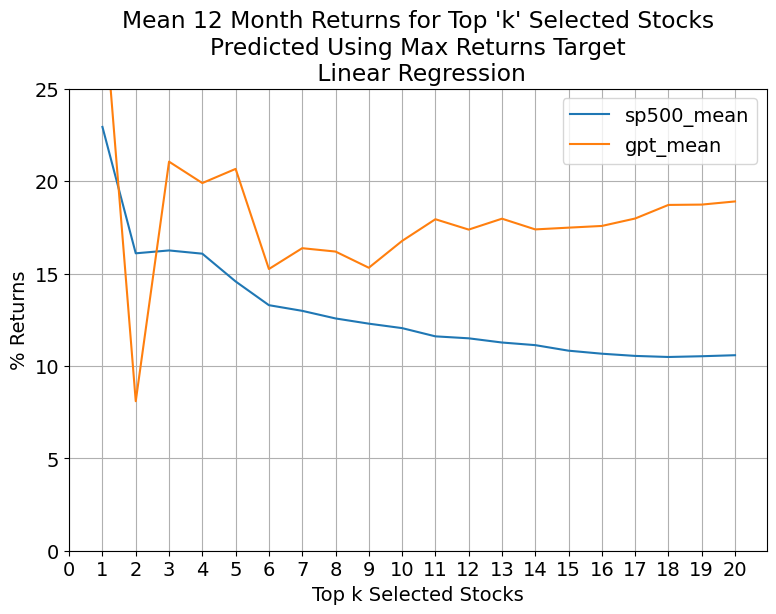

In [192]:
df_eval_max.loc[:, ['sp500_mean', 'gpt_mean']].plot(figsize=(9,6))
plt.grid()
plt.title("Mean 12 Month Returns for Top 'k' Selected Stocks\nPredicted Using Max Returns Target\n Linear Regression")
plt.ylabel('% Returns')
plt.ylim(0, 25)
plt.xticks(range(0, 21, 1))
plt.xlabel('Top k Selected Stocks')
#plt.savefig("plots/12mReturns_maxTarget.png", dpi=300)

##Calculate Value of $1 invested at start of 2018

In [193]:
def plot_accumulated_value(df_test, top_k, returns_col, pred_col, title):
    top_pred_id_list = list(df_test.groupby('era', group_keys=False).apply(lambda d: d.sort_values(by=pred_col, ascending=False)\
                                                                           .iloc[:top_k]['symbol']))
    df_toppred = df_test.loc[lambda x: x['symbol'].isin(top_pred_id_list)].sort_values(by='era')

    account_sp500 = [1]
    account_gpt = [1]
    for era_tuple in df_toppred.groupby('era'):
        era = era_tuple[0]
        era_df = era_tuple[1]
        sp500_returns = era_df['sp500_{}'.format(returns_col)].mean()
        gpt_returns = era_df['target_{}'.format(returns_col)].mean()
        #Compute new account value based on current percent returns
        new_account_sp500 = account_sp500[-1] * (1 + sp500_returns/100.0)
        new_account_gpt = account_gpt[-1] * (1 + gpt_returns/100.0)
        account_sp500.append(new_account_sp500)
        account_gpt.append(new_account_gpt)

    fig, ax = plt.subplots(1,1, figsize=(9,7))
    ax.plot(range(2018, 2024), account_sp500, label='S&P 500')
    ax.plot(range(2018, 2024), account_gpt, label='GPT')
    ax.set_ylabel('Cumulative Amount')
    ax.set_xlabel('Year')
    ax.set_title(title)
    ax.grid()
    ax.legend()
    return fig, ax

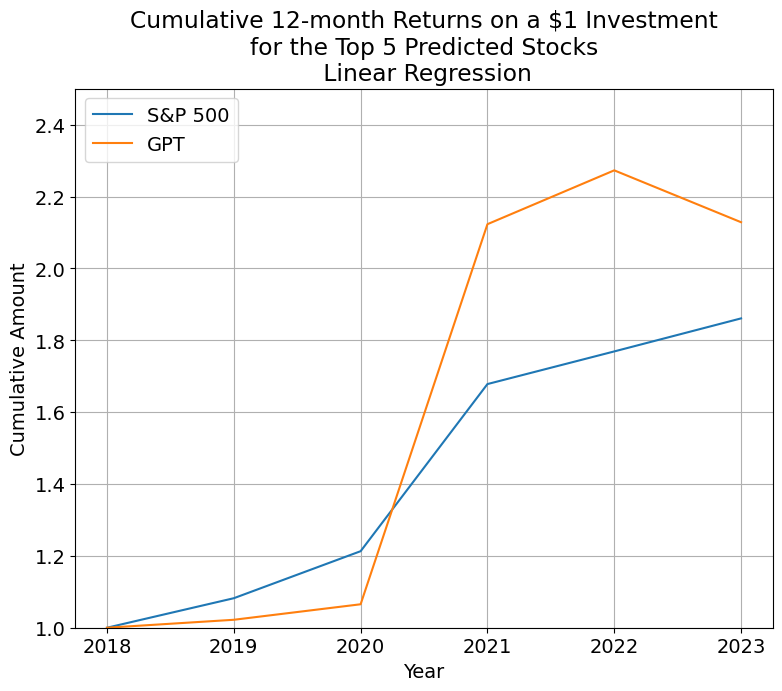

In [194]:
fig, ax = plot_accumulated_value(df_test, 5, returns_col='12m', pred_col='pred_reg_12m',
                                title='Cumulative 12-month Returns on a $1 Investment\nfor the Top 5 Predicted Stocks\n Linear Regression')
ax.set_ylim(1, 2.5)
ax.legend(loc='upper left')
#fig.savefig('plots/cumulative_12mReturns_12mTarget.png', dpi=300)

## Elastic Net Regression Model



In [195]:
from sklearn.linear_model import ElasticNet

alpha = 1.0  # overall regularization strength, you can adjust this parameter
l1_ratio = 0.5  # mixing parameter for L1 regularization, you can adjust this parameter

reg_12m = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True).fit(df_train[feature_cols], df_train['target_12m_normalised'])
reg_max = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=True).fit(df_train[feature_cols], df_train['target_min_normalised'])

df_test['pred_reg_12m'] = reg_12m.predict(df_test[feature_cols])
df_test['pred_reg_max'] = reg_max.predict(df_test[feature_cols])


In [196]:
#Find top stocks based on prediction by 'reg_12m' model.
#Calculate returns for entire 12 month duration
df_eval_12m = pd.DataFrame()

#k denotes the number of top stocks to be selected per year.
for k in range(1, 21):
    curr_df = pd.DataFrame.from_dict(calc_returns(df_test, k, returns_col='12m', pred_col='pred_reg_12m'), orient='index').T
    curr_df.set_index('top_k', inplace=True)
    df_eval_12m = pd.concat([df_eval_12m, curr_df], ignore_index=False)

Text(0.5, 0, 'Top k Selected Stocks')

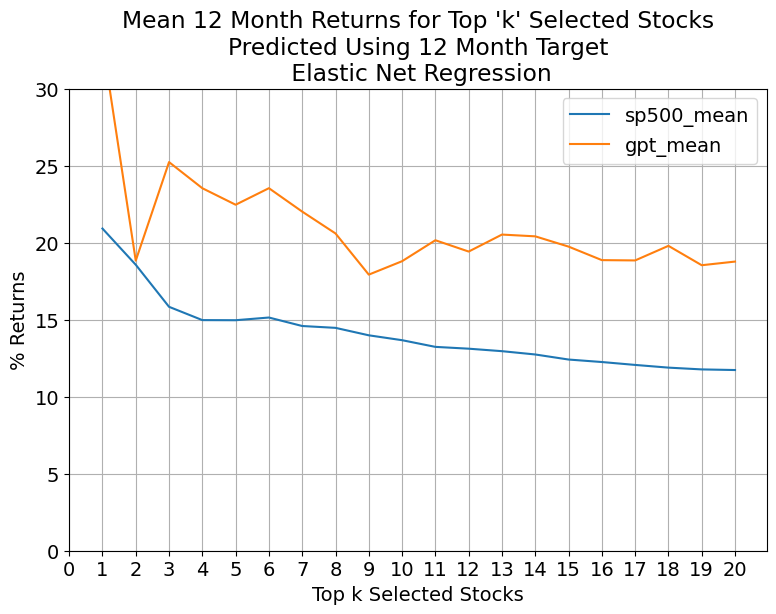

In [197]:
df_eval_12m.loc[:, ['sp500_mean', 'gpt_mean']].plot(figsize=(9,6))
plt.grid()
plt.title("Mean 12 Month Returns for Top 'k' Selected Stocks\nPredicted Using 12 Month Target\n Elastic Net Regression")
plt.ylabel('% Returns')
plt.ylim(0, 30)
plt.xticks(range(0, 21, 1))
plt.xlabel('Top k Selected Stocks')
#plt.savefig("plots/12mReturns_12mTarget.png", dpi=300)

In [198]:
#Find top stocks based on prediction by 'reg_max' model.
#Calculate returns for entire 12 month duration
df_eval_max = pd.DataFrame()

#k denotes the number of top stocks to be selected per year.
for k in range(1, 21):
    curr_df = pd.DataFrame.from_dict(calc_returns(df_test, k, returns_col='12m', pred_col='pred_reg_max'), orient='index').T
    curr_df.set_index('top_k', inplace=True)
    df_eval_max = pd.concat([df_eval_max, curr_df], ignore_index=False)

Text(0.5, 0, 'Top k Selected Stocks')

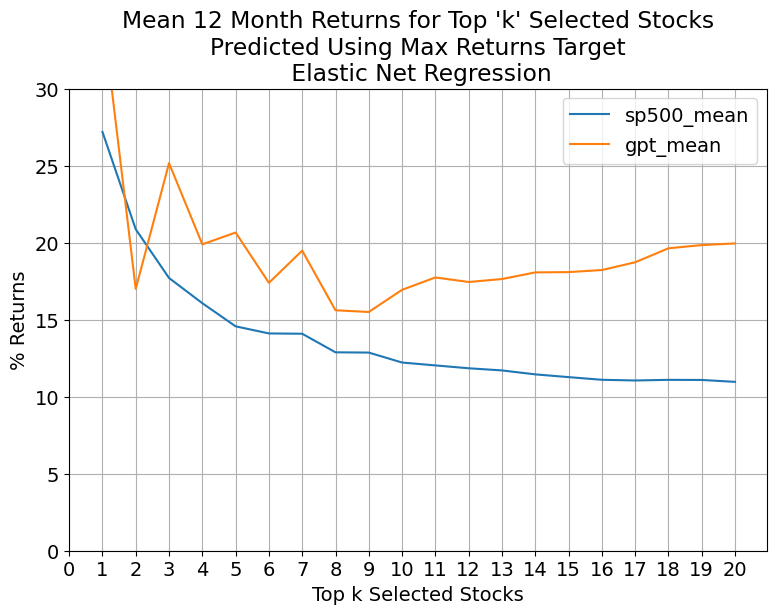

In [199]:
df_eval_max.loc[:, ['sp500_mean', 'gpt_mean']].plot(figsize=(9,6))
plt.grid()
plt.title("Mean 12 Month Returns for Top 'k' Selected Stocks\nPredicted Using Max Returns Target\n Elastic Net Regression")
plt.ylabel('% Returns')
plt.ylim(0, 30)
plt.xticks(range(0, 21, 1))
plt.xlabel('Top k Selected Stocks')
#plt.savefig("plots/12mReturns_maxTarget.png", dpi=300)

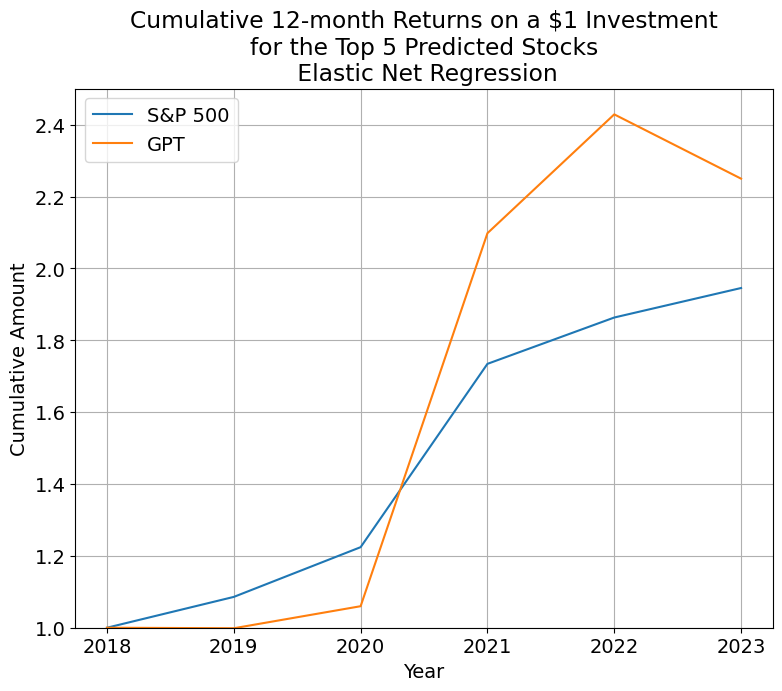

In [200]:
fig, ax = plot_accumulated_value(df_test, 5, returns_col='12m', pred_col='pred_reg_12m',
                                title='Cumulative 12-month Returns on a $1 Investment\nfor the Top 5 Predicted Stocks\n Elastic Net Regression')
ax.set_ylim(1, 2.5)
ax.legend(loc='upper left')
#fig.savefig('plots/cumulative_12mReturns_12mTarget.png', dpi=300)

### Conclusion: **Elestic Net Regression** outperfromes Linear Regression interms of predicting **Percentage Returns** and **Cummulative Returns.**